In [1]:
!pip install bertopic
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 101.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import numpy as np 
import pandas as pd 
import sys
import re
import time
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/producers-direct-2/producersdirectdata.parquet


In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "producersdirectdata.parquet"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ariellien/producers-direct-2",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Combine both language conditions using the logical AND operator (&)
both_eng_mask = (df['response_language'].str.contains('eng', case=False, na=False)) & \
                (df['question_language'].str.contains('eng', case=False, na=False))

# Apply the combined mask to filter the DataFrame. Using .copy() to avoid SettingWithCopyWarning.
df1 = df[both_eng_mask].copy()

# Select the required columns for analysis
CHALLENGE_4_COLUMNS = [
    'question_id',
    'question_topic',
    'question_content',
    'response_content',
    'question_sent',
    'question_user_country_code',
    'question_language',
    'response_language',
]
df1 = df1[CHALLENGE_4_COLUMNS]

# --- B. Data Cleaning and Classification ---

# 1. NaN Handling
# Fill NaN values in the 'question_topic' column with 'General_Topic'
df1['question_topic'].fillna('General_Topic', inplace=True)


# 2. Text Cleaning (Creating 'question_content_cleaned')
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'^[qes][\s\.\-]*', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Create the cleaned content column
df1['question_content_cleaned'] = df1['question_content'].apply(clean_text)


# 3. Binary Topic Classification
# List of topics considered 'General' or non-specific
GENERAL_TOPICS_LIST = [
    'General_Topic', 'crop', 'plant', 'animal', 'tree', 'livestock',
    'vegetable', 'bird', 'grass', 'market', 'dog', 'cat', 'poultry'
]

# Create the broad_topic column: Correctly use df1['question_topic'] for the operation
df1['broad_topic'] = df1['question_topic'].apply(
    lambda x: 'General' if x in GENERAL_TOPICS_LIST else 'Specific (Crop/Livestock)'
)

df1.to_csv('df1.csv', index = False)

/tmp/ipykernel_48/1177513247.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [8]:
#df1 = pd.read_csv('/kaggle/working/df1.csv')

In [5]:
general_index = df1['broad_topic'] == 'General'
df1 = df1[general_index]
df1 = df1[:100000]

In [14]:
import time
import numpy as np 
import pandas as pd
from sentence_transformers import SentenceTransformer 
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer 
from umap import UMAP
import sys
import seaborn as sns 

start_time = time.time()

# --- 0. Define Seed Topics for Guided Topic Modeling ---
# BERTopic requires seed words to be placed in a list of lists.
seed_topic_list = [
    # 1. Market and Finance
    ['market', 'price', 'cost', 'sell', 'buy', 'money', 'business', 'loan', 'credit'],
    # 2. Pests and Diseases
    ['pest', 'disease', 'spray', 'chemical', 'deworm', 'vaccinate', 'coccidiosis', 'mastitis', 'armyworm', 'fungus', 'sick', 'treatment'],
    # 3. Weather and Climate
    ['weather', 'rain', 'drought', 'climate', 'flood', 'season', 'wet', 'dry', 'hot', 'cold'],
    # 4. Fundamental Knowledge and Concepts
    ['what is', 'meaning of', 'define', 'explain', 'what are', 'causes', 'which plant', 'which crop', 'how to', 'how can'],
    # 5. Livestock and Animals (Focus on animals)
    ['pigs', 'cow', 'hens', 'rabbit', 'cattle', 'animal', 'milk', 'chicken', 'poultry', 'livestock'],  
    # 6. Soil and Water Management
    ['soil', 'erosion', 'ph', 'fertilizer', 'irrigation', 'water', 'manure', 'compost'],
    # 7. Farming Technique and Crops (Focus on general planting methods and common crops)
    ['farming', 'plant', 'grow', 'pruning', 'weeding', 'cultivation', 'seed', 'harrowing', 'method', 'way', 'process', 'cabbage', 'tomato', 'vegetables'],
    # 8. NEW: Feed and Forage - Key: Isolating specific feed items (e.g., grass, maize)
    ['feed', 'grass', 'forage', 'maize', 'fodder', 'stapier', 'napier', 'sorghum'],
]

# --- 1. Configuration ---
TEXT_COLUMN = 'question_content_cleaned' 
OUTPUT_FILE = 'bertopic_guided_subtopics_results.csv'
EMBEDDING_MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2' 
MIN_TOPIC_SIZE = 1000  # Key setting for 100k records: forces large, stable clusters
TOP_N_WORDS = 10  # Number of words to represent each topic


# --- 2. Data Preparation (Assuming df1 is available) ---
df_clean = df1.dropna(subset=[TEXT_COLUMN]).reset_index(drop=True)
docs = df_clean[TEXT_COLUMN].tolist()

print(f"--- Data Source: df1 ({len(df_clean)} rows) ---")


# --- 3. Initialize and Train BERTopic Model (Guided) ---
print("\n--- 3. Initializing and Training BERTopic Model (Guided) ---")

# a. Initialize Sentence Transformer Model and generate embeddings (Will automatically use GPU)
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
# ⚠️ WARNING: This step is computationally intensive and benefits greatly from GPU/Save & Run All
embeddings = embedding_model.encode(docs, show_progress_bar=True) 

# 1. Create optimized UMAP Model (Dimensionality Reduction)
umap_model = UMAP(
    n_neighbors=75,          # Increase neighbors for smoother embedding space (less fragmentation)
    min_dist=0.05,           # Increase min_dist to prevent overly dense initial clusters
    n_components=5,          # Standard dimension size (5-15 is typical)
    metric='cosine',
    random_state=42
)

# b. Create optimized CountVectorizer (Feature Extraction)
vectorizer_model = CountVectorizer(
    stop_words=["the", "a", "an", "is", "of", "and", "or", "for", "in", "it"], # Custom stop words to preserve 'how', 'do', etc.
    ngram_range=(1, 2),      # Include Bigrams (e.g., "fall armyworm")
    min_df=0.001             # Filter out words appearing in less than 0.1% of documents (noise filter)
)

# c. Initialize BERTopic Model (Pass the guided parameters)
topic_model = BERTopic(
    language="english", 
    top_n_words=TOP_N_WORDS, 
    min_topic_size=MIN_TOPIC_SIZE, 
    verbose=True,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    seed_topic_list=seed_topic_list # <--- Key Parameter: Guides the clustering direction towards predefined concepts
)

# d. Train the model
print("3d. Performing Dimensionality Reduction, Clustering, and Topic Extraction...")
topics, probabilities = topic_model.fit_transform(docs, embeddings=embeddings)


# --- 4. Extract, Output, and Create Simplified Labels ---

df_clean['BERTopic_Topic_ID'] = topics
topics_info = topic_model.get_topic_info()

# Create BERTopic default Name Label (BERTopic_Label)
topic_label_map = dict(zip(topics_info['Topic'], topics_info['Name']))
df_clean['BERTopic_Label'] = df_clean['BERTopic_Topic_ID'].apply(
    lambda topic_id: topic_label_map.get(topic_id, 'Unclassified')
)

# Create simplified Topic_Key_Label (1-2 words for quick readability)
def create_key_label(topic_name):
    if topic_name.startswith('-1_'):
        return "Noise"
    try:
        parts = topic_name.split('_')
        if len(parts) >= 3:
            # Extract word 1 and 2, and capitalize
            return f"{parts[1].capitalize()} {parts[2].capitalize()}"
        elif len(parts) == 2:
            # Only one word found
            return parts[1].capitalize()
        else:
            return "Vague"
    except:
        return "Vague"

topic_key_label_map = dict(zip(topics_info['Topic'], topics_info['Name'].apply(create_key_label)))
df_clean['Topic_Key_Label'] = df_clean['BERTopic_Topic_ID'].apply(
    lambda topic_id: topic_key_label_map.get(topic_id, 'Unclassified')
)

df_clean.to_csv(OUTPUT_FILE, index=False)


# --- 5. End Timing and Display Results ---
end_time = time.time()
elapsed_time = end_time - start_time

print("\n-------------------------------------------")
print(f"✅ BERTopic Model Training Complete!")
print(f"Total documents processed: {len(docs)}")
print(f"Total runtime (including embedding generation): {elapsed_time:.2f} seconds")
print("-------------------------------------------")

# Display topic summary
print("\nDiscovered Topic Summary (Top 20):")
print(topics_info.head(20))

# Display data preview
print("\nData Preview with BERTopic Results:")
print(df_clean[[TEXT_COLUMN, 'BERTopic_Topic_ID', 'BERTopic_Label', 'Topic_Key_Label']].head(10))

--- 數據源: df1 (100000 行) ---

--- 3. 正在初始化和訓練 BERTopic 模型 (指導中) ---


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2025-11-13 20:04:04,989 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


3d. 正在進行降維、聚類與主題提取...


2025-11-13 20:10:44,073 - BERTopic - Dimensionality - Completed ✓
2025-11-13 20:10:44,079 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-13 20:11:39,180 - BERTopic - Cluster - Completed ✓
2025-11-13 20:11:39,199 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-13 20:11:40,832 - BERTopic - Representation - Completed ✓



-------------------------------------------
✅ BERTopic 建模完成！
總共處理了 100000 筆數據。
總耗時 (包含嵌入生成): 528.85 秒
-------------------------------------------

發現的主題資訊 (前 20 個):
    Topic  Count                                     Name  \
0      -1  62038                     -1_plant_to_what_can   
1       0   6757                 0_poultry_start_birds_to   
2       1   6559                     1_what_where_you_how   
3       2   6157                    2_spray_control_to_my   
4       3   6111               3_animal_milk_animals_what   
5       4   2859             4_maize_plant_to plant_which   
6       5   2789                  5_plant_where_seeds_get   
7       6   1740               6_fertilizer_soil_which_to   
8       7   1380             7_wefarm_farmers_farmer_farm   
9       8   1301              8_army_worms_worm_army worm   
10      9   1170      9_banana_plant_plant banana_bananas   
11     10   1139  10_tomatoes_tomato_plant_plant tomatoes   

                                       R

In [15]:
#df_clean.to_csv('bertopic.csv', index = False)

In [19]:
df_clean['BERTopic_Topic_ID'].value_counts()

0


BERTopic_Topic_ID
-1     62038
 0      6757
 1      6559
 2      6157
 3      6111
 4      2859
 5      2789
 6      1740
 7      1380
 8      1301
 9      1170
 10     1139
Name: count, dtype: int64

Visualization generated: 'bertopic_overall_distribution_full_label_final.png'.


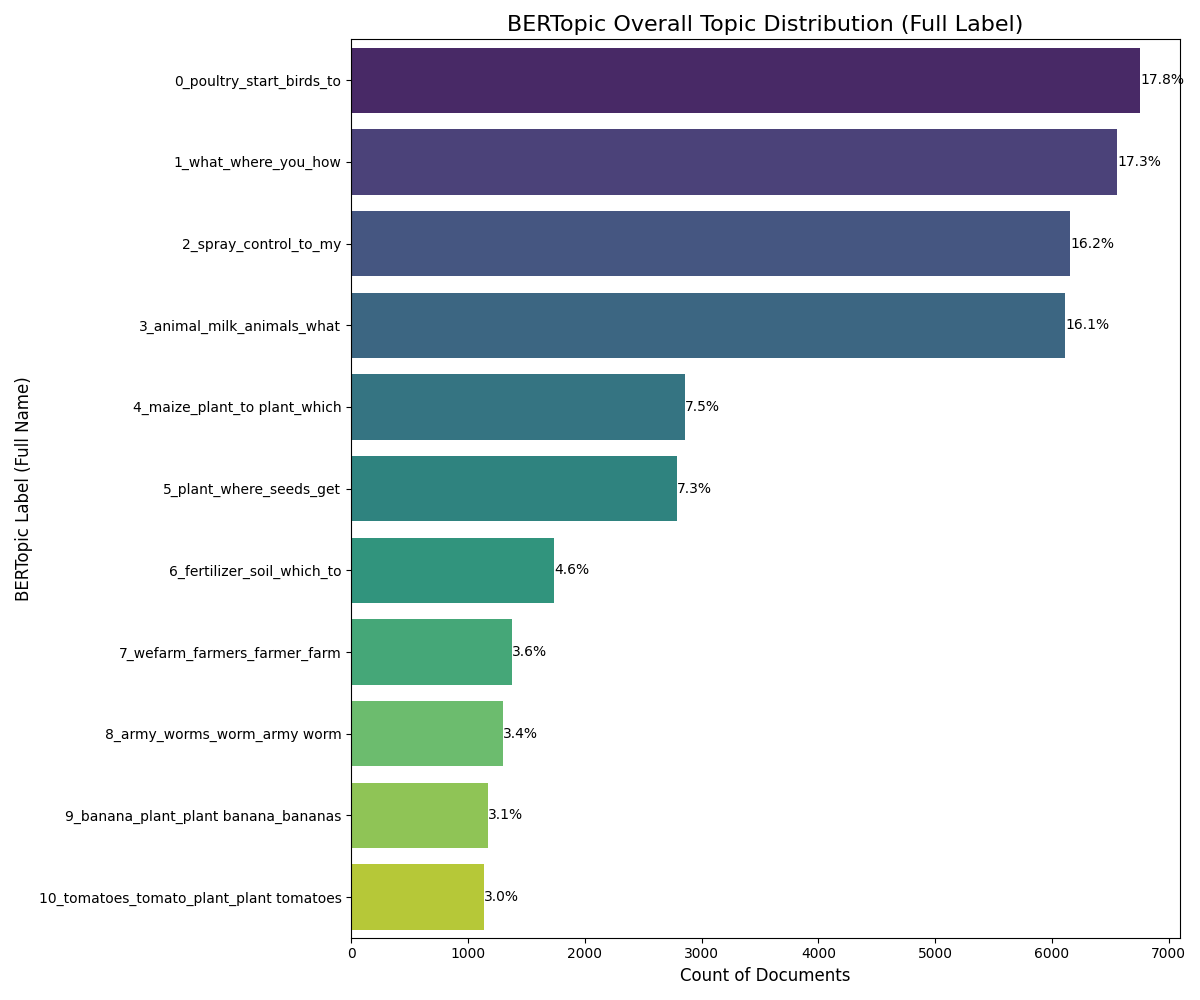

In [17]:
label_col = 'BERTopic_Label' #BERTopic_Label,  Topic_Key_Label
# 2. Prepare data for visualization (using the full label)
# Filter out Noise (-1) - Assuming noise label starts with '-1_' in BERTopic_Label
df_clean1 = df_clean[df_clean[label_col].str.startswith('-1_') == False].copy()

# Calculate the count and proportion
topic_counts = df_clean1[label_col].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
total_count = topic_counts['Count'].sum()

# Sort by Count (descending)
topic_counts = topic_counts.sort_values(by='Count', ascending=False)

# --- 3. Create the Bar Chart (Full Label) ---
plt.figure(figsize=(12, 10)) # Increased size for long labels
sns.barplot(
    x='Count', 
    y='Topic', 
    data=topic_counts, 
    palette='viridis'
)

# Add percentage labels (using total_count calculated above)
for index, row in topic_counts.iterrows():
    percentage = f"{(row['Count'] / total_count) * 100:.1f}%"
    plt.text(row['Count'], index, percentage, color='black', ha="left", va="center")


plt.title('BERTopic Overall Topic Distribution (Full Label)', fontsize=16)
plt.xlabel('Count of Documents', fontsize=12)
plt.ylabel('BERTopic Label (Full Name)', fontsize=12)
plt.tight_layout()
plt.savefig('bertopic_overall_distribution_full_label_final.png')
plt.close()

print("Visualization generated: 'bertopic_overall_distribution_full_label_final.png'.")
Image(filename='bertopic_overall_distribution_full_label_final.png')